In [430]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')

In [779]:
class Event:
    def __init__(self, time_since_last_trigger_us, timestamp_us, nhits, digit_pmt_id, digit_time_ns, digit_ncrossings, log_pmt_id, log_time_ns): 
        # Global event data
        self.time_since_last_trigger_us = time_since_last_trigger_us
        self.timestamp_us = timestamp_us
        self.nhits = nhits
        self.trigger_type = None # 0=prompt 1=follower
        self.time_since_last_prompt_trigger_us = None

        # Arrays with PMT information 
        self.digit_pmt_id = digit_pmt_id 
        self.digit_ncrossings = digit_ncrossings 
        self.digit_time_ns = digit_time_ns
        self.log_pmt_id = log_pmt_id 
        self.log_time_ns = log_time_ns 

    def print(self):
        print("---------------------------------------")
        print(f"                     Timestamp : {self.timestamp_us:.3f} us")
        print(f"       Time since last trigger : {self.time_since_last_trigger_us:.3f} us ")
        print(f"                  Trigger Type : {self.trigger_type}")
        print(f"Time since last prompt trigger : {self.time_since_last_prompt_trigger_us}")
        print(f"                         NHits : {self.nhits}")


class Run:
    def __init__(self,number):
        # Run data
        self.number = number 
        self.files = []

        # Meta data (non event dependent)
        self.pmt_type = None
        self.pmt_id = None
        self.pmt_ch = None
        self.pmt_is_online = None
        self.pmt_cable_offset = None

        # Event data
        self.events = []

    # Load data for the run
    def load_files(self, path):
        path = Path(path)
        files = list(path.glob("*/*.root"))
        for f in files:
            if f"run{self.number}" in f.as_posix():
                self.files.append(f)
        self.files = sorted(self.files, key=lambda x: int(x.stem.split('_')[3].split('.')[0]))
        print(f"Found {len(self.files)} files for run {self.number}")
        self.files=self.files[:200]

    # Can open any one of the run files to get this
    def load_meta_data(self):
        f=up.open(self.files[0])

        self.pmt_type = f['meta']['pmtType'].array(library='np')[0]
        self.pmt_id = f['meta']['pmtId'].array(library='np')[0]
        self.pmt_ch = f['meta']['pmtChannel'].array(library='np')[0]
        self.pmt_is_online = f['meta']['pmtIsOnline'].array(library='np')[0]
        self.pmt_cable_offset = f['meta']['pmtCableOffset'].array(library='np')[0]

    # Must open all the files (assume events in file are in order - timestamp is just wrong)
    def load_event_data(self):
        last_file_end_timestamp_us = 0 # for continuity across files

        for file in tqdm(self.files, desc=f"Parsing {len(self.files)} files for run {self.number}", colour='green'):
            f=up.open(file)

            nhits = f['output']['digitNhits'].array(library='ak')
            digit_pmt_id = f['output']['digitPMTID'].array(library='ak')
            digit_time_ns = f['output']['digitTime'].array(library='ak')
            digit_ncrossings = f['output']['digitNCrossings'].array(library='ak')
            log_pmt_id = f['output']['fit_pmtid_Lognormal'].array(library='ak')
            log_time = f['output']['fit_time_Lognormal'].array(library='ak')

            # Make timestamp using relative trigger times
            time_since_last_trigger_us = f['output']['timeSinceLastTrigger_us'].array(library='ak')
            time_since_last_trigger_us = ak.to_numpy(time_since_last_trigger_us)  # Convert to NumPy array
            time_since_last_trigger_us[time_since_last_trigger_us > 1e6] = 10000  # Replace large values with 0.01 s

            timestamp_us = np.cumsum(time_since_last_trigger_us) + last_file_end_timestamp_us
            last_file_end_timestamp_us = timestamp_us[-1]
            
            # Create event instances
            for i in range(len(nhits)):
                event = Event(
                    time_since_last_trigger_us[i],
                    timestamp_us[i],
                    nhits[i],
                    digit_pmt_id[i],
                    digit_time_ns[i],
                    digit_ncrossings[i],
                    log_pmt_id[i],
                    log_time[i]
                )
                self.events.append(event)

    def reset_trigger_types(self):
        for event in self.events:
            event.trigger_type = None

    def set_trigger_types(self,prompt_nhit_range, follower_nhit_range):
        for event in self.events:
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1 
            
    def set_time_since_last_promp_trigger(self):
        prompt_time = 0
        for event in self.events:
            if event.trigger_type==0:
                prompt_time = event.timestamp_us
            else:
                event.time_since_last_prompt_trigger_us = event.timestamp_us - prompt_time

    def reset_time_since_last_prompt_trigger(self):
        for event in self.events:
            event.time_since_last_prompt_trigger_us = None
                
    def get_time_since_last_trigger_us(self):
        return [event.time_since_last_trigger_us for event in self.events]

    def get_time_since_last_prompt_trigger_us(self):
        return [event.time_since_last_prompt_trigger_us for event in self.events]

    def get_timestamp_us(self):
        return [event.timestamp_us for event in self.events]
    
    def get_nhits(self):
        return [event.nhits for event in self.events]
    
    def get_digit_pmt_id(self):
        return [event.digit_pmt_id for event in self.events]
    
    def get_digit_time_ns(self):
        return [event.digit_time_ns for event in self.events]
    
    def get_digit_ncrossings(self):
        return [event.digit_ncrossings for event in self.events]
    
    def get_log_pmt_id(self):
        return [event.log_pmt_id for event in self.events]
    
    def get_log_time_ns(self):
        return [event.log_time_ns for event in self.events]
    


In [780]:
path = '/nfs/disk1/eos/eos-processed-data-nubar/'

run = Run(1246)
run.load_files(path)
run.load_meta_data()
run.load_event_data()



Found 1157 files for run 1246


Parsing 200 files for run 1246:   0%|          | 0/200 [00:00<?, ?it/s]

Parsing 200 files for run 1246: 100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


In [858]:
prompt_nhit_range = (135,200)
follower_nhit_range = (65,135)

run.reset_trigger_types()
run.reset_time_since_last_prompt_trigger()

run.set_trigger_types(prompt_nhit_range, follower_nhit_range)
run.set_time_since_last_promp_trigger()

nprompt = [event.trigger_type==0 for event in run.events].count(True)
print(f"{nprompt} prompt triggers found")
nfollower= [event.trigger_type==1 for event in run.events].count(True)
print(f"{nfollower} follower triggers found")
nbad = [event.trigger_type==None for event in run.events].count(True)
print(f"{nbad} bad triggers found")

nhits = run.get_nhits()
ts = run.get_timestamp_us()
dt = run.get_time_since_last_trigger_us()
dt_prompt = run.get_time_since_last_prompt_trigger_us()

print(f"Got {ts[-1]/1e6:.3f} s of data")





444974 prompt triggers found
201701 follower triggers found
1082325 bad triggers found
Got 4279.581 s of data


In [859]:
# for event in run.events:
#     event.print()


Text(1, 0, 'Total NHits per Event')

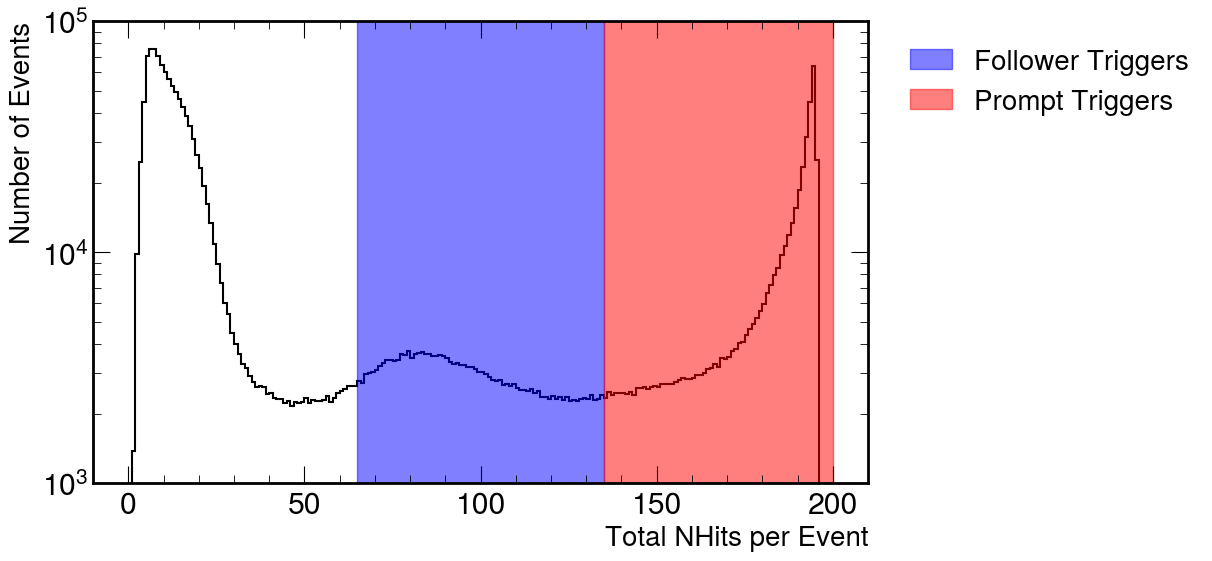

In [860]:
nhits = run.get_nhits()

plt.figure(figsize=(10, 6))
hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), color='black')
plt.axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Triggers')
plt.axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Triggers')
plt.legend(loc='upper right',bbox_to_anchor=(1.45, 1),fontsize=20)
plt.ylim(1e3,1e5)
plt.yscale('log')
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('Total NHits per Event', fontsize=20)

201701 201701


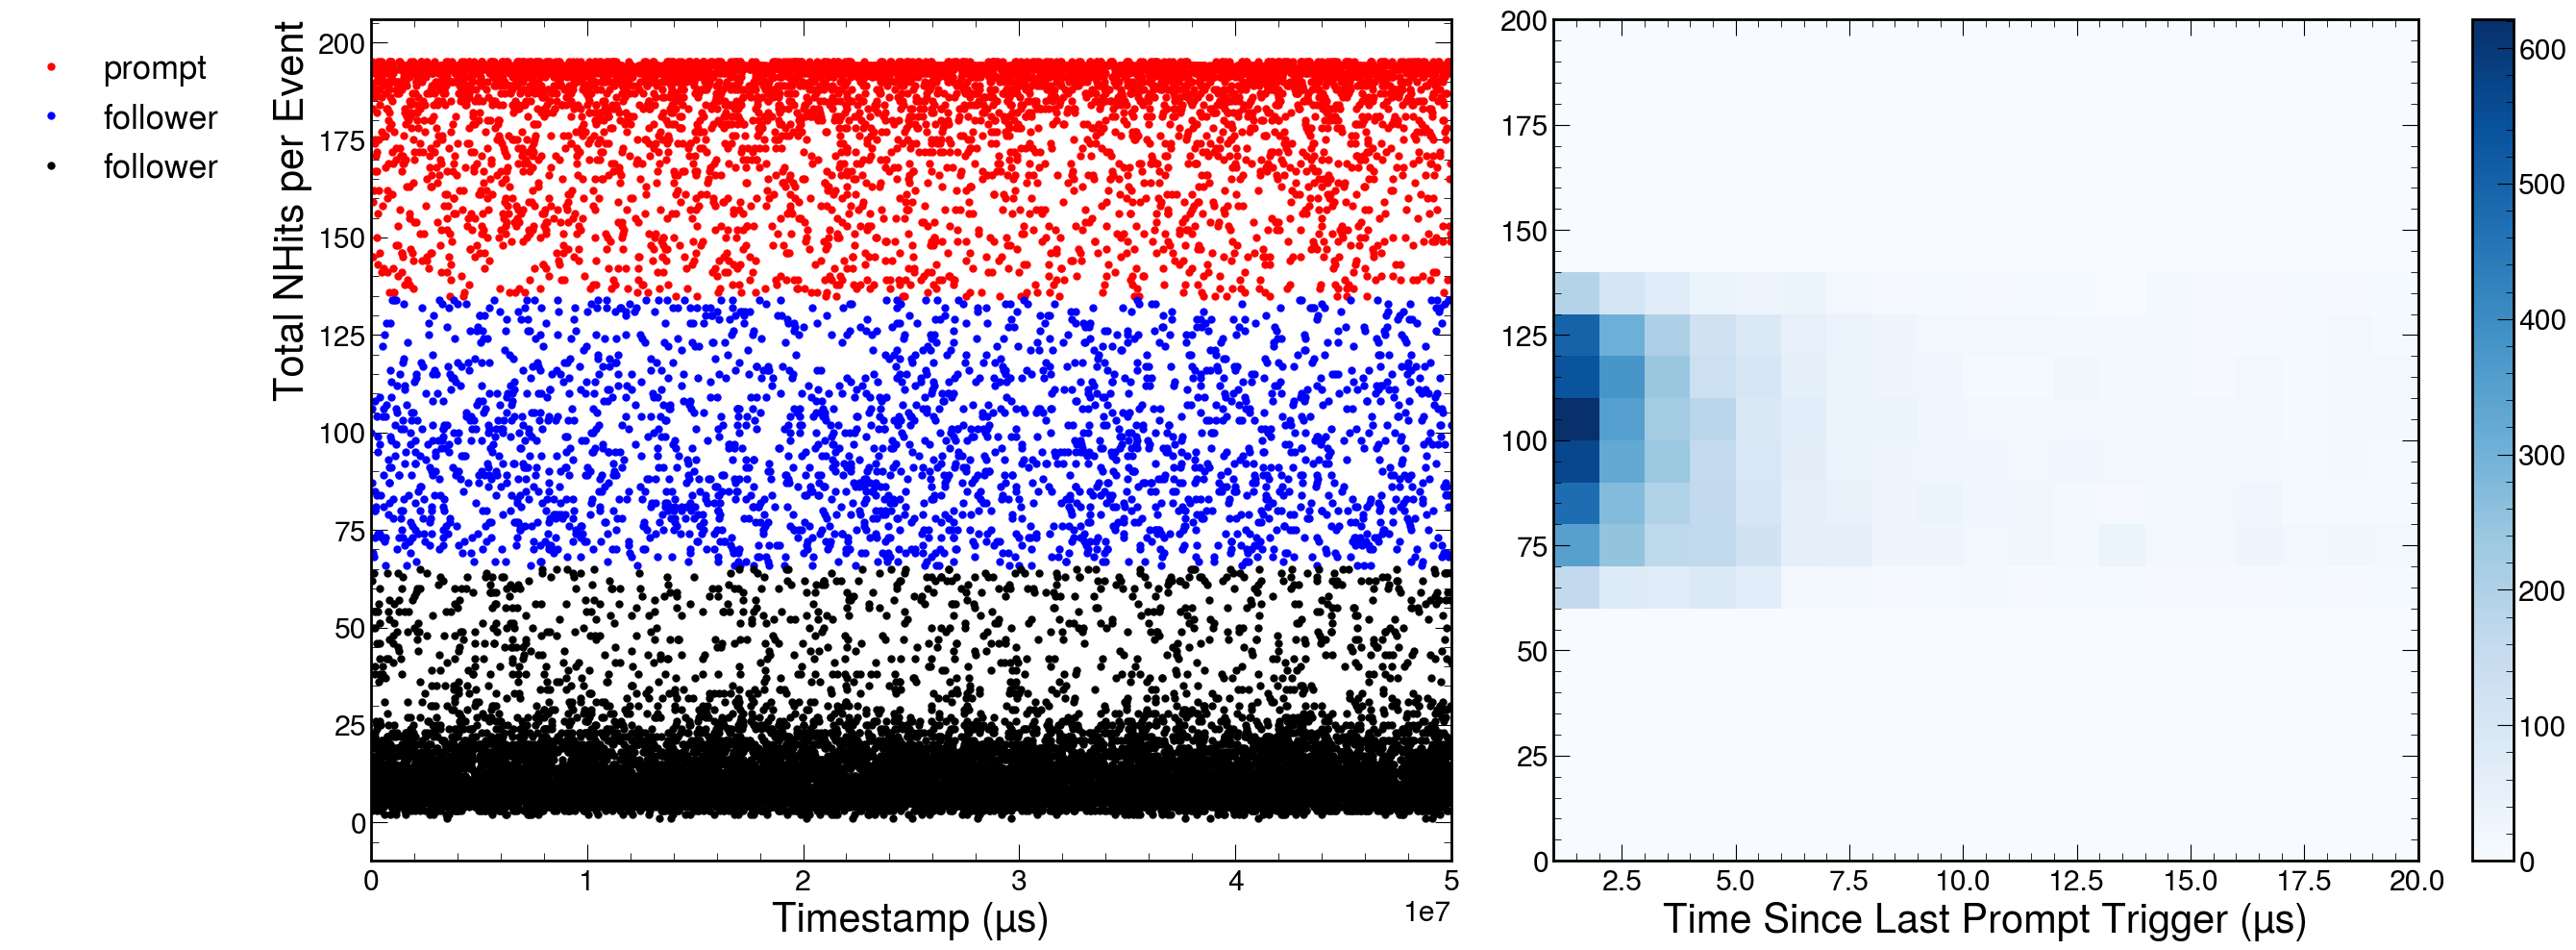

In [861]:
ts_prompt = [event.timestamp_us for event in run.events if event.trigger_type==0]
ts_follower = [event.timestamp_us for event in run.events if event.trigger_type==1]
ts_bad = [event.timestamp_us for event in run.events if event.trigger_type==None]

deltat = [event.time_since_last_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1]
print(len(deltat),len(deltat_follower))

nhits_prompt = [event.nhits for event in run.events if event.trigger_type==0]
nhits_follower = [event.nhits for event in run.events if event.trigger_type==1]
nhits_bad = [event.nhits for event in run.events if event.trigger_type==None]

fig, ax = plt.subplots(1,2,figsize=(25, 10))
fig.tight_layout()
ax[0].plot(ts_prompt, nhits_prompt, 'o', markersize=5, label='prompt', color='red')
ax[0].plot(ts_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
ax[0].plot(ts_bad, nhits_bad, 'o', markersize=5, label='follower', color='black')
ax[0].set_xlabel('Timestamp (µs)', loc='center',fontsize=30)
ax[0].set_ylabel('Total NHits per Event', fontsize=30)
ax[0].set_xlim(0, 5e7)
ax[0].legend(loc='upper left',bbox_to_anchor=(-0.35, 1),fontsize=25)
#ax[1].plot(deltat_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
hd = ax[1].hist2d(deltat_follower, nhits_follower, bins=(19, 20), range=((1, 20), (0,200)), cmap='Blues')
ax[1].set_xlabel('Time Since Last Prompt Trigger (µs)', loc='center', fontsize=30)
ax[1].set_xlim(1,20)
#ax[1].set_ylim(follower_nhit_range[0], follower_nhit_range[1])  
fig.colorbar(hd[3],ax=ax[1])
#ax[2].plot(deltat, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hdf = ax[2].hist2d(deltat, nhits_follower, bins=(19, 20), range=((1, 20), (0, 200)), cmap='Blues')
# ax[2].set_xlabel('Time since last trigger (us)', fontsize=20)
# ax[2].set_xlim(1,20)
# fig.colorbar(hdf[3],ax=ax[2])

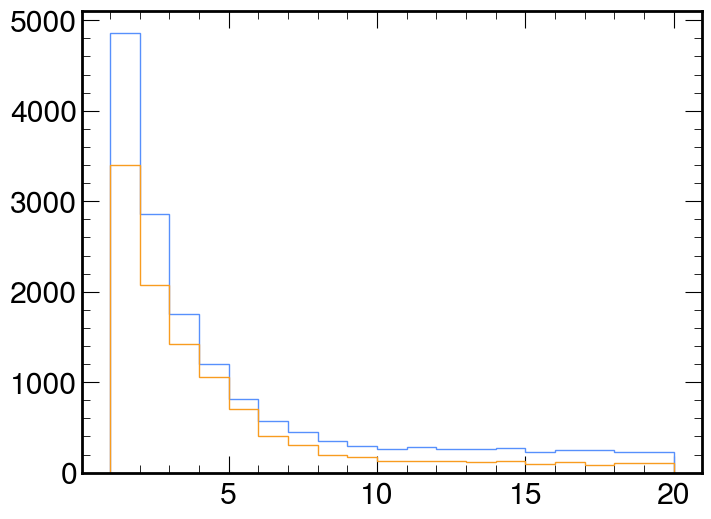

In [862]:
plt.figure(figsize=(8, 6))
plt.hist(deltat, bins=19, range=(1, 20), histtype='step', label='Follower')
plt.hist(deltat_follower, bins=19, range=(1, 20), histtype='step', label='Follower');

Fit results:
A = 14284.185 ± 171.936
tau = 2.203 ± 0.035
B = 96.654 ± 3.665
Chi2 = 47.855
Chi2/dof = 2.991


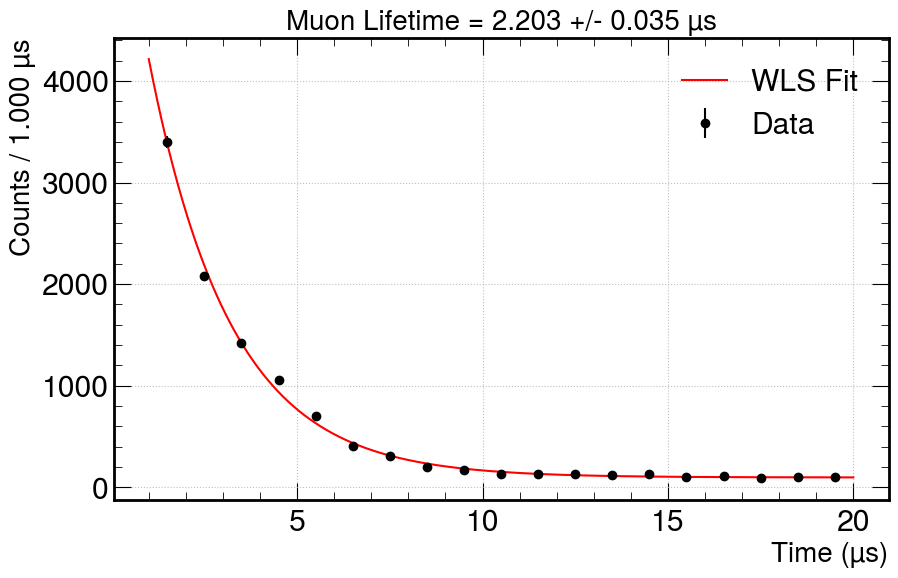

In [864]:

def fit_decay_hist(data):

    bins = 19
    range = (1, 20)

    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    sigma = np.sqrt(counts)

    def decay_model(t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B
    
    # Initial guess for the parameters
    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    tau_guess = 2
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma, absolute_sigma=True, p0=p0, maxfev=100000) 

    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    print("Fit results:")
    print(f"A = {A_fit:.3f} ± {A_err:.3f}")
    print(f"tau = {tau_fit:.3f} ± {tau_err:.3f}")
    print(f"B = {B_fit:.3f} ± {B_err:.3f}")
    print(f"Chi2 = {chi2:.3f}")
    print(f"Chi2/dof = {chi2_red:.3f}")

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label='Data')
    t_fine = np.linspace(*range, 1000)
    plt.plot(t_fine, decay_model(t_fine, *popt), color='red', label='WLS Fit')
    plt.xlabel('Time (µs)', fontsize=20)
    plt.ylabel(f"Counts / {(range[-1]-range[0])/bins:.3f} µs",fontsize=20)
    plt.title(f"Muon Lifetime = {tau_fit:.3f} +/- {tau_err:.3f} µs",fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()

fit_decay_hist(deltat_follower)
